In [2]:
## General ML libraries
import torch
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

2024-02-09 02:24:52.688885: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 02:24:52.688912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 02:24:52.689864: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-09 02:24:52.695486: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-09 02:24:53.348370: W tensorflow/comp

In [2]:
##### MNIST

In [3]:
#from architecture import INN as inn
from functionalities import dataloader as dl
#from functionalities import evaluater as ev
#from functionalities import loss as lo
from functionalities import trainer as tr

from tqdm import tqdm_notebook as tqdm
from functionalities import tracker as tk
from functionalities import MMD_autoencoder_loss as cl
from functionalities import filemanager as fm
from functionalities import plot as pl
from functionalities import gpu

In [4]:
from FrEIA import framework as fr
from FrEIA.modules import coeff_functs as fu
from FrEIA.modules import coupling_layers as la
from FrEIA.modules import reshapes as re

In [5]:
def mnist_inn_com(mask_size=[28, 28]):
    """
    Return an autoencoder.

    :param mask_size: size of the input. Default: Size of MNIST images
    :return:
    """

    img_dims = [1, mask_size[0], mask_size[1]]

    inp = fr.InputNode(*img_dims, name='input')

    r1 = fr.Node([inp.out0], re.haar_multiplex_layer, {}, name='r1')

    conv1 = fr.Node([r1.out0], la.glow_coupling_layer, {'F_class': fu.F_conv,
                    'F_args': {'channels_hidden': 100}, 'clamp': 1}, name='conv1')

    conv2 = fr.Node([conv1.out0], la.glow_coupling_layer, {'F_class': fu.F_conv,
                    'F_args': {'channels_hidden': 100}, 'clamp': 1}, name='conv2')

    conv3 = fr.Node([conv2.out0], la.glow_coupling_layer, {'F_class': fu.F_conv,
                    'F_args': {'channels_hidden': 100}, 'clamp': 1}, name='conv3')

    r2 = fr.Node([conv3.out0], re.reshape_layer, {'target_dim': (img_dims[0]*img_dims[1]*img_dims[2],)}, name='r2')

    fc = fr.Node([r2.out0], la.rev_multiplicative_layer, {'F_class': fu.F_small_connected, 'F_args': {'internal_size': 180}, 'clamp': 1}, name='fc')

    r3 = fr.Node([fc.out0], re.reshape_layer, {'target_dim': (4, 14, 14)}, name='r3')

    r4 = fr.Node([r3.out0], re.haar_restore_layer, {}, name='r4')

    outp = fr.OutputNode([r4.out0], name='output')

    nodes = [inp, outp, conv1, conv2, conv3, r1, r2, r3, r4, fc]

    coder = fr.ReversibleGraphNet(nodes, 0, 1)

    return coder

In [6]:
### Pretraining Setup
num_epoch = 5
batch_size = 128
latent_dim_lst = [2] #[8, 16, 64]  #[1, 2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64]
number_dev = 0
lr_init = 1e-3
l2_reg  = 1e-6
milestones = [2] #[8, 10]
modelname = 'mnist_INN_glow_com_bottleneck'
get_model = mnist_inn_com

device = gpu.get_device(number_dev)
print(device)

cuda


In [7]:
trainset, testset, classes = dl.load_mnist()
trainloader, validloader, testloader = dl.make_dataloaders(trainset, testset, batch_size)

In [8]:
# Train INN model
def train(num_epoch, model, modelname, criterion, optimizer, scheduler, latent_dim, trainloader, validloader=None,
          testloader=None, conditional=False, disc_lst=None, use_label=False, tracker=None, device='cpu', save_model=True, save_variable=True, subdir=None, num_epoch_save=10,
          num_img=100, grid_row_size=10):
    """
    Train a INN model.
    :param num_epoch: number of training epochs
    :param model: INN that should be trained
    :param modelname: model name under which the model should be saved
    :param criterion: the criterion to compute the loss
    :param optimizer: the optimization method used for training
    :param scheduler: pytorch scheduler for adaptive learning
    :param latent_dim: dimension of the latent space
    :param trainloader: the training set wrapped by a loader
    :param validloader: the validation set wrapped by a loader
    :param testloader: the test set wrapped by a loader
    :param disc_lst: If given the first latent dimension will be enforced to be discrete depending on the values given
    in disc_lst
    :param use_label: If true, the labels will be used to help enforcing the first latent dimension to be discrete
    :param tracker: tracker for values during training
    :param device: device on which to do the computation (CPU or CUDA). Please use get_device() function to get the
    device, if using multiple GPU's. Default: cpu
    :param save_model: If True save model and model weights. Default: True
    :param save_variable: If True save all loss histories. Default: True
    :param subdir: subdirectory to save the model in
    :param num_epoch_save: number of epochs after which a sample of reconstructed images will be saved
    :return: model (trained model)
    """
    print("TRAIN")
    print("conditonal=", conditional)
    model.to(device)

    tot_loss_log = []
    tot_valid_loss_log = []
    tot_test_loss_log = []
    rec_loss_log = []
    rec_valid_loss_log = []
    rec_test_loss_log = []
    dist_loss_log = []
    dist_valid_loss_log = []
    dist_test_loss_log = []
    spar_loss_log = []
    spar_valid_loss_log = []
    spar_test_loss_log = []
    disen_loss_log = []
    disen_valid_loss_log = []
    disen_test_loss_log =[]
    disc_loss_log = []
    disc_valid_loss_log = []
    disc_test_loss_log = []
    min_loss = 10e300
    best_epoch = 0
    num_step = 0

    for epoch in range(num_epoch):
        model.train()

        if disc_lst is not None or conditional:
            losses = np.zeros(6, dtype=np.double)
        else:
            losses = np.zeros(5, dtype=np.double)
            losses_list = [[],[],[],[],[]]

        print('length of losses:', len(losses))

        scheduler.step()

        print('Epoch: {}'.format(epoch + 1))
        print('Training:')

        correct = 0

        for i, data in enumerate(tqdm(trainloader), 0):
            criterion.update_num_step(num_step)
            num_step += 1
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            #print("inputs.shape: ", inputs.shape) # inputs.shape:  torch.Size([128, 1, 28, 28])

            optimizer.zero_grad()

            lat_img = model(inputs)
            lat_shape = lat_img.shape
            #print("lat_image: ", lat_img)
            #print("lat_image.shape: ", lat_img.shape) # lat_image.shape:  torch.Size([128, 1, 28, 28])

            # This is needed to crete artificial bottkeneck - part of the vector after latnet_dim will be filled with zeros
            lat_img = lat_img.view(lat_img.size(0), -1)
            #print("lat_image_view: ", lat_img)
            #print("lat_image_view.shape: ", lat_img.shape) # lat_image_view.shape:  torch.Size([128, 784])

            if conditional:
                binary_label = lat_img.new_zeros(lat_img.size(0), 10)
                idx = torch.arange(labels.size(0), dtype=torch.long)
                binary_label[idx, labels] = 1
                lat_img_mod = torch.cat([lat_img[:, :latent_dim], binary_label, lat_img.new_zeros((lat_img[:, latent_dim+10:]).shape)], dim=1)
                pred = lat_img[:, latent_dim:latent_dim+10].max(1, keepdim=True)[1]
                correct += pred.eq(labels.view_as(pred)).sum().item()
            elif use_label and disc_lst is not None:
                disc_lst = torch.tensor(disc_lst).to(device).float()
                disc_lat_dim = disc_lst[labels]
                lat_img_mod = torch.cat([torch.unsqueeze(disc_lat_dim, 1).float(), lat_img[:, 1:latent_dim],
                                         lat_img.new_zeros((lat_img[:, latent_dim:]).shape).float()], dim=1)
                pred = disc_lst[torch.min(torch.abs(lat_img[:, :1] - disc_lst), 1)[1]] * 10
                correct += pred.eq(labels.float().view_as(pred)).sum().item()
            elif disc_lst is not None:
                disc_lst = torch.tensor(disc_lst).to(device)
                disc_lat_idx = torch.min(torch.abs(lat_img[:,:1] - disc_lst), 1)[1]
                disc_lat_dim = disc_lst[disc_lat_idx]
                lat_img_mod = torch.cat([torch.unsqueeze(disc_lat_dim, 1), lat_img[:, 1:latent_dim],
                                         lat_img.new_zeros((lat_img[:, latent_dim:]).shape)], dim=1)
            else:
                # this is what gets executed
                lat_img_mod = torch.cat([lat_img[:, :latent_dim], lat_img.new_zeros((lat_img[:, latent_dim:]).shape)], dim=1)


            lat_img_mod = lat_img_mod.view(lat_shape)
            #print ("lat_img_mode.shape: ", lat_img_mod.shape) # lat_img_mod.shape:  torch.Size([128, 1, 28, 28])
            #print ("lat_img_mod: ", lat_img_mod)

            # lat_img_mod:  tensor([[[[-0.0097, -0.0754,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
            #                    [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],



            output = model(lat_img_mod, rev=True)


            if conditional:
                batch_loss = criterion(inputs, lat_img, output, labels, binary_label)
            elif use_label:
                batch_loss = criterion(inputs, lat_img, output, labels)
            else:
                batch_loss = criterion(inputs, lat_img, output)
                #print("batch_loss:", batch_loss) #new

            batch_loss[0].backward()

            optimizer.step()

            for i in range(len(batch_loss)):
                losses[i] += batch_loss[i].item()
                losses_list[i].append(batch_loss[i].item())
            # print("losses_list:", losses_list)  #new

        correct = correct * 100. / len(trainloader.dataset)
        losses /= len(trainloader)
        tot_loss_log.append(losses[0])
        rec_loss_log.append(losses[1])
        dist_loss_log.append(losses[2])
        spar_loss_log.append(losses[3])
        disen_loss_log.append(losses[4])
        if len(losses) == 6:
            disc_loss_log.append(losses[5])
            print('Loss: {:.3f} \t L_rec: {:.3f} \t L_dist: {:.3f} \t L_spar: {:.3f} \t L_disen: {:.3f} \t L_disc: {:.3f}'.format(
                losses[0], losses[1], losses[2], losses[3], losses[4], losses[5]))
            print('Train Accuracy: {:.1f}'.format(correct))
        else:
            print('Loss: {:.3f} \t L_rec: {:.3f} \t L_dist: {:.3f} \t L_spar: {:.3f} \t L_disen: {:.3f}'.format(
                losses[0], losses[1], losses[2], losses[3], losses[4]))

        if validloader is not None:
            print('\n')
            print('Compute and record loss on validation set')
            #valid_loss = ev.get_loss(validloader, model, criterion, latent_dim, tracker, conditional, disc_lst, use_label, device)
            valid_loss = get_loss(validloader, model, criterion, latent_dim, tracker, conditional, disc_lst, use_label, device)
            tot_valid_loss_log.append(valid_loss[0])
            rec_valid_loss_log.append(valid_loss[1])
            dist_valid_loss_log.append(valid_loss[2])
            spar_valid_loss_log.append(valid_loss[3])
            disen_valid_loss_log.append(valid_loss[4])
            if len(valid_loss) == 6:
                disc_valid_loss_log.append(valid_loss[5])
                print('Loss: {:.3f} \t L_rec: {:.3f} \t L_dist: {:.3f} \t L_spar: {:.3f} \t L_disen: {:.3f} \t L_disc: {:.3f}'.format(
                    valid_loss[0], valid_loss[1], valid_loss[2], valid_loss[3], valid_loss[4], valid_loss[5]))
            else:
                print('Loss: {:.3f} \t L_rec: {:.3f} \t L_dist: {:.3f} \t L_spar: {:.3f} \t L_disen: {:.3f}'.format(
                    valid_loss[0], valid_loss[1], valid_loss[2], valid_loss[3], valid_loss[4]))

            print('latent image mean: {:.3f} \t latent image std: {:.3f}'.format(tracker.mu, tracker.std))

            if valid_loss[0] <= min_loss:
                last_best_epoch = best_epoch
                best_epoch = epoch + 1
                min_loss = valid_loss[0]
                fm.save_model(model, "{}_{}_best".format(modelname, best_epoch))
                fm.save_weight(model, "{}_{}_best".format(modelname, best_epoch))
                if last_best_epoch != 0:
                    fm.delete_file("models", "{}_{}_best".format(modelname, last_best_epoch))
                    fm.delete_file("weights", "{}_{}_best".format(modelname, last_best_epoch))

        if testloader is not None:
            print('\n')
            print('Compute and record loss on test set:')
            #test_loss = ev.get_loss(testloader, model, criterion, latent_dim, tracker, conditional, disc_lst, use_label, device)
            test_loss = get_loss(testloader, model, criterion, latent_dim, tracker, conditional, disc_lst, use_label, device)
            tot_test_loss_log.append(test_loss[0])
            rec_test_loss_log.append(test_loss[1])
            dist_test_loss_log.append(test_loss[2])
            spar_test_loss_log.append(test_loss[3])
            disen_test_loss_log.append(test_loss[4])
            if len(test_loss) == 6:
                disc_test_loss_log.append(test_loss[5])
                print('Loss: {:.3f} \t L_rec: {:.3f} \t L_dist: {:.3f} \t L_spar: {:.3f} \t L_disen: {:.3f} \t L_disc: {:.3f}'.format(
                    test_loss[0], test_loss[1], test_loss[2], test_loss[3], test_loss[4], test_loss[5]))
            else:
                print('Loss: {:.3f} \t L_rec: {:.3f} \t L_dist: {:.3f} \t L_spar: {:.3f} \t L_disen: {:.3f}'.format(
                    test_loss[0], test_loss[1], test_loss[2], test_loss[3], test_loss[4]))

            print('latent image mean: {:.3f} \t latent image std: {:.3f}'.format(tracker.mu, tracker.std))

        if epoch % num_epoch_save == 0 or epoch == (num_epoch - 1):
            pl.plot_diff(model, testloader, latent_dim, device, num_img, grid_row_size, filename=modelname + "_{}".format(epoch))

        print('\n')
        print('-' * 80)
        print('\n')

    if validloader is not None:
        print("Lowest Validation Loss: {:3f} was achieved at epoch: {}".format(min_loss, best_epoch))

    print("Finished Training")

    if subdir is None:
        subdir = modelname

    if save_model:
        model.to('cpu')
        fm.save_model(model, "{}_{}".format(modelname, num_epoch), subdir)
        fm.save_weight(model, "{}_{}".format(modelname, num_epoch), subdir)

    if save_variable:
        fm.save_variable([tot_loss_log, tot_valid_loss_log, tot_test_loss_log],
                         "total_loss_{}_{}".format(modelname, num_epoch), subdir)
        fm.save_variable([rec_loss_log, rec_valid_loss_log, rec_test_loss_log],
                         "reconstruction_loss_{}_{}".format(modelname, num_epoch), subdir)
        fm.save_variable([dist_loss_log, dist_valid_loss_log, dist_test_loss_log],
                         "distribution_loss_{}_{}".format(modelname, num_epoch), subdir)
        fm.save_variable([spar_loss_log, spar_valid_loss_log, spar_test_loss_log],
                         "sparsity_loss_{}_{}".format(modelname, num_epoch), subdir)
        fm.save_variable([disen_loss_log, disen_valid_loss_log, disen_test_loss_log],
                         "disentanglement_loss_{}_{}".format(modelname, num_epoch), subdir)
        fm.save_variable([disc_loss_log, disc_valid_loss_log, disc_test_loss_log],
                         "discrete_loss_{}_{}".format(modelname, num_epoch), subdir)
        fm.save_variable([tot_loss_log, rec_loss_log, dist_loss_log, spar_loss_log, disen_loss_log, disc_loss_log],
                         "train_loss_{}_{}".format(modelname, num_epoch), subdir)
        fm.save_variable([tot_valid_loss_log, rec_valid_loss_log, dist_valid_loss_log, spar_valid_loss_log,
                          disen_valid_loss_log, disc_loss_log], "validation_loss_{}_{}".format(modelname, num_epoch), subdir)
        fm.save_variable([tot_test_loss_log, rec_test_loss_log, dist_test_loss_log, spar_test_loss_log,
                          disen_test_loss_log, disc_loss_log], "test_loss_{}_{}".format(modelname, num_epoch), subdir)

    return model

In [9]:
def init_model(get_model, latent_dim, loss_type, device, a_distr=1, a_rec=1, a_spar=1, a_disen=1, a_disc=0, conditional=False, disc_lst=None, use_lat_dim=False, cont_min=None, cont_max=None, num_iter=None, init_weight=True):
    """
    Initialize the INN model.
    :param get_model: function that returns the INN that should be trained
    :param latent_dim: dimension of the latent space
    :param loss_type: type of reconstruction loss to use
    :param device: device on which to do the computation (CPU or CUDA). Please use get_device() function to get the
    device, if using multiple GPU's. Default: cpu
    :param a_distr: factor for distribution loss
    :param a_rec: factor for reconstruction loss
    :param a_spar: factor for sparsity loss
    :param a_disen: factor for disentanglement
    :param use_lat_dim: get_model needs latent dimension as argument
    :return: model: Initialized model
             model_params: parameters of the model
             track: tracker for values during training
             loss: class to compute the total loss
    """

    if use_lat_dim:
        model = get_model(latent_dim)
    else:
        model = get_model()

    if init_weight:
        init_param(model)

    model.train()

    model.to(device)

    if disc_lst is not None:
        disc_lst = torch.tensor(disc_lst).to(device)

    model_params = []
    for parameter in model.parameters():
        if parameter.requires_grad:
            model_params.append(parameter)

    track = tk.tracker(latent_dim)

    loss = cl.MMD_autoencoder_loss(a_distr=a_distr, a_rec=a_rec, a_spar=a_spar, a_disen=a_disen, a_disc=a_disc, latent_dim=latent_dim, loss_type=loss_type, device=device, conditional=conditional, disc_lst=disc_lst, cont_min=cont_min, cont_max=cont_max, num_iter=num_iter)

    return model, model_params, track, loss


def init_training(model_params, lr_init, l2_reg, milestones):
    """
    Initialize optimizer and scheduler for training.
    :param model_params: parameters of the model
    :param lr_init: initial learning rate
    :param l2_reg: weight decay for Adam
    :param milestones: list of training epochs in which to reduce the learning rate
    :return: optimizer, scheduler
    """

    optimizer = torch.optim.Adam(model_params, lr=lr_init, betas=(0.8, 0.8), eps=1e-04, weight_decay=l2_reg)

    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    return optimizer, scheduler


def init_param(mod, sigma = 0.1):
    """
    Weight intialization for INN models.
    """
    for key, param in mod.named_parameters():
        split = key.split('.')
        if param.requires_grad:
            param.data = sigma * torch.randn(param.data.shape) #.cuda()
            if split[3][-1] == '3': # last convolution in the coeff func
                param.data.fill_(0.)

In [10]:
def get_loss(loader, model, criterion, latent_dim, tracker, conditional=False, disc_lst=None, use_label=False, device='cpu'):

    #train_losses = get_loss(trainloader, model, criterion, latent_dim, track, device)
    """
    Compute the loss of a model on a train, test or evalutation set wrapped by a loader.
    :param loader: loader that wraps the train, test or evaluation set
    :param model: model that should be tested
    :param criterion: the criterion to compute the loss
    :param latent_dim: dimension of the latent space
    :param tracker: tracker for values during training
    :param disc_lst: If given the first latent dimension will be enforced to be discrete depending on the values given
    in disc_lst
    :param use_label: If true, the labels will be used to help enforcing the first latent dimension to be discrete
    :param device: device on which to do the computation (CPU or CUDA). Please use get_device() function to get the
    device, if using multiple GPU's. Default: cpu
    :return: losses
    """
    print("EVAL")
    print("conditonal=", conditional)
    print("device=", device)
    model.to(device)

    model.eval()

    if disc_lst is not None or conditional:
        losses = np.zeros(6, dtype=np.double)
    else:
        losses = np.zeros(5, dtype=np.double)

    tracker.reset()

    correct = 0

    for i, data in enumerate(tqdm(loader), 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            lat_img = model(inputs)
            lat_shape = lat_img.shape
            lat_img = lat_img.view(lat_img.size(0), -1)

            if conditional:
                binary_label = lat_img.new_zeros(lat_img.size(0), 10)
                idx = torch.arange(labels.size(0), dtype=torch.long)
                binary_label[idx, labels] = 1
                lat_img_mod = torch.cat([lat_img[:,:latent_dim], binary_label, lat_img.new_zeros((lat_img[:,latent_dim+10:]).shape)], dim=1)
                pred = lat_img[:, latent_dim:latent_dim+10].max(1, keepdim=True)[1]
                correct += pred.eq(labels.view_as(pred)).sum().item()
            elif use_label and disc_lst is not None:
                disc_lst = torch.tensor(disc_lst).to(device)
                disc_lat_dim = disc_lst[labels]
                lat_img_mod = torch.cat([torch.unsqueeze(disc_lat_dim, 1), lat_img[:, 1:latent_dim],
                                         lat_img.new_zeros((lat_img[:, latent_dim:]).shape)], dim=1)
                pred = disc_lst[torch.min(torch.abs(lat_img[:, :1] - disc_lst), 1)[1]] * 10
                correct += pred.eq(labels.float().view_as(pred)).sum().item()
            elif disc_lst is not None:
                disc_lst = torch.tensor(disc_lst).to(device)
                disc_lat_idx = torch.min(torch.abs(lat_img[:, :1] - disc_lst), 1)[1]
                disc_lat_dim = disc_lst[disc_lat_idx]
                lat_img_mod = torch.cat([torch.unsqueeze(disc_lat_dim, 1), lat_img[:, 1:latent_dim],
                                         lat_img.new_zeros((lat_img[:, latent_dim:]).shape)], dim=1)
            else:
                lat_img_mod = torch.cat([lat_img[:, :latent_dim], lat_img.new_zeros((lat_img[:, latent_dim:]).shape)], dim=1)

            lat_img_mod = lat_img_mod.view(lat_shape)

            output = model(lat_img_mod, rev=True)

            if use_label:
                batch_loss = criterion(inputs, lat_img.to(device), output.to(device), labels)
            else:
                batch_loss = criterion(inputs, lat_img.to(device), output.to(device))

            for i in range(len(batch_loss)):
                losses[i] += batch_loss[i].item()

            tracker.update(lat_img)

    correct = correct * 100. / len(loader.dataset)
    if use_label or conditional:
        print('Test Accuracy: {:.1f}'.format(correct))
    losses /= len(loader)
    return losses


def get_loss_bottleneck(loader, modelname, subdir, latent_dim_lst, device, a_distr, a_rec, a_spar, a_disen):
    """
    :return:
    """

    total_loss = []
    rec_loss = []
    dist_loss = []
    spar_loss = []
    disen_loss = []

    for i in latent_dim_lst:
        print('bottleneck dimension: {}'.format(i))
        model = fm.load_model('{}_{}'.format(modelname, i).to(device), subdir)
        criterion = cl.MMD_autoencoder_loss(a_distr=a_distr, a_rec=a_rec, a_spar=a_spar, a_disen=a_disen, latent_dim=i, loss_type='l1', device=device)
        losses = get_loss(loader, model, criterion, i, device)
        total_loss.append(losses[0])
        rec_loss.append(losses[1])
        dist_loss.append(losses[2])
        spar_loss.append(losses[3])
        disen_loss.append(losses[4])

    return total_loss, rec_loss, dist_loss, spar_loss, disen_loss

In [11]:
def train_bottleneck(num_epoch, get_model, loss_type, modelname, milestones, latent_dim_lst, trainloader,
                     validloader=None, testloader=None, a_distr=1, a_rec=1, a_spar=1, a_disen=1, lr_init=1e-3,
                     l2_reg=1e-6, conditional=False, disc_lst=None, use_label=False, device='cpu', save_model=False,
                     save_variable=True, use_lat_dim=False, num_epoch_save=10, num_img=100, grid_row_size=10):
    """
    Train INN model for various bottleneck sizes.
    :param num_epoch: number of training epochs
    :param get_model: function that returns the INN that should be trained
    :param loss_type: type of reconstruction loss to use
    :param modelname: model name under which the model should be saved
    :param milestones: list of training epochs in which to reduce the learning rate
    :param latent_dim_lst: a list of latent space dimensions
    :param trainloader: the training set wrapped by a loader
    :param validloader: the validation set wrapped by a loader
    :param testloader: the test set wrapped by a loader
    :param a_distr: factor for distribution loss (see CIFAR_coder_loss)
    :param a_rec: factor for reconstruction loss (see CIFAR_coder_loss)
    :param a_spar: factor for sparsity loss (see CIFAR_coder_loss)
    :param a_disen: factor for disentanglement loss (see CIFAR_coder_loss)
    :param lr_init: initial learning rate
    :param l2_reg: weight decay for Adam
    :param device: device on which to do the computation (CPU or CUDA). Use get_device() function to get the
    device, if using multiple GPU's. Default: cpu
    :param save_model: If True save model and model weights. Default: True
    :param save_variable: If True save all loss histories. Default: True
    :param use_lat_dim: get_model needs latent dimension as argument
    :param num_epoch_save: number of epochs after which a sample of reconstructed images will be saved
    :return: None
    """
    print("TRAIN BOTTLENECK")

    tot_train_loss_log = []
    rec_train_loss_log = []
    dist_train_loss_log = []
    spar_train_loss_log = []
    disen_train_loss_log = []
    tot_test_loss_log = []
    rec_test_loss_log = []
    dist_test_loss_log = []
    spar_test_loss_log = []
    disen_test_loss_log = []

    for latent_dim in latent_dim_lst:
        print("\n")
        print("Start Training with latent dimension: {}".format(latent_dim))
        print('\n')

        model, model_params, track, criterion = init_model(get_model, latent_dim, loss_type, device, a_distr, a_rec,
                                                           a_spar, a_disen, use_lat_dim)
        print ("after init_model")
        optimizer, scheduler = init_training(model_params, lr_init, l2_reg, milestones)
        print ("after init_training")
        model.to(device)

        model = train(num_epoch, model, modelname + "_{}".format(latent_dim), criterion, optimizer, scheduler,
                      latent_dim, trainloader, validloader, testloader, conditional, disc_lst, use_label, track, device, save_model,
                      save_variable, modelname + "_bottleneck", num_epoch_save, num_img, grid_row_size)

        print("conditonal=", conditional)

        train_losses = [0,0,0,0,0]
        #train_losses = get_loss(trainloader, model, criterion, latent_dim, track, conditional, disc_lst, use_label, device=device)

        tot_train_loss_log.append(train_losses[0])
        rec_train_loss_log.append(train_losses[1])
        dist_train_loss_log.append(train_losses[2])
        spar_train_loss_log.append(train_losses[3])
        disen_train_loss_log.append(train_losses[4])

        losses = [0,0,0,0,0]
        #losses = get_loss(testloader, model, criterion, latent_dim, track, conditional, disc_lst, use_label, device=device)
        #######losses = get_loss(trainloader, model, criterion, latent_dim, track, conditional, disc_lst, use_label, device=device)
        tot_test_loss_log.append(losses[0])
        rec_test_loss_log.append(losses[1])
        dist_test_loss_log.append(losses[2])
        spar_test_loss_log.append(losses[3])
        disen_test_loss_log.append(losses[4])

        print("\n")
        print("#" * 80)
        print("#" * 80)
        print("\n")

    fm.save_variable([tot_test_loss_log, rec_test_loss_log, dist_test_loss_log, spar_test_loss_log,
                      disen_test_loss_log], "bottleneck_test_loss_{}".format(modelname), modelname)

    fm.save_variable([tot_train_loss_log, rec_train_loss_log, dist_train_loss_log, spar_train_loss_log,
                      disen_train_loss_log], "bottleneck_train_loss_{}".format(modelname), modelname)

    return model

In [12]:
model = get_model(mask_size=[28, 28])

Node r1 has following input dimensions:
	 Output #0 of node input: (1, 28, 28)

Node conv1 has following input dimensions:
	 Output #0 of node r1: (4, 14, 14)

Node conv2 has following input dimensions:
	 Output #0 of node conv1: (4, 14, 14)

Node conv3 has following input dimensions:
	 Output #0 of node conv2: (4, 14, 14)

Node r2 has following input dimensions:
	 Output #0 of node conv3: (4, 14, 14)

internal_size: 180
internal_size: 180
internal_size: 180
internal_size: 180
Node fc has following input dimensions:
	 Output #0 of node r2: (784,)

Node r3 has following input dimensions:
	 Output #0 of node fc: (784,)

Node r4 has following input dimensions:
	 Output #0 of node r3: (4, 14, 14)

Node output has following input dimensions:
	 Output #0 of node r4: (1, 28, 28)



In [13]:
train_losses = [0,0,0,0,0]

In [14]:
### Pretraining Setup
num_epoch = 10
batch_size = 128
latent_dim_lst = [4] #[8, 16, 64]  #[1, 2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64]
number_dev = 0
lr_init = 1e-3
l2_reg  = 1e-6
milestones = [4] #[8, 10]
modelname = 'mnist_INN_glow_com_bottleneck'
get_model = mnist_inn_com

device = gpu.get_device(number_dev)
print(device)

cuda


TRAIN BOTTLENECK


Start Training with latent dimension: 4


Node r1 has following input dimensions:
	 Output #0 of node input: (1, 28, 28)

Node conv1 has following input dimensions:
	 Output #0 of node r1: (4, 14, 14)

Node conv2 has following input dimensions:
	 Output #0 of node conv1: (4, 14, 14)

Node conv3 has following input dimensions:
	 Output #0 of node conv2: (4, 14, 14)

Node r2 has following input dimensions:
	 Output #0 of node conv3: (4, 14, 14)

internal_size: 180
internal_size: 180
internal_size: 180
internal_size: 180
Node fc has following input dimensions:
	 Output #0 of node r2: (784,)

Node r3 has following input dimensions:
	 Output #0 of node fc: (784,)

Node r4 has following input dimensions:
	 Output #0 of node r3: (4, 14, 14)

Node output has following input dimensions:
	 Output #0 of node r4: (1, 28, 28)

after init_model
after init_training
TRAIN
conditonal= False
length of losses: 5
Epoch: 1
Training:


/home/abx4kb/.conda/envs/venv-p310-torch210-abx4kb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/tmp/ipykernel_88554/640956139.py:73: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in enumerate(tqdm(trainloader), 0):


  0%|          | 0/468 [00:00<?, ?it/s]

Loss: 0.128 	 L_rec: 0.124 	 L_dist: 0.000 	 L_spar: 0.004 	 L_disen: 0.000


Compute and record loss on test set:
EVAL
conditonal= False
device= cuda


/tmp/ipykernel_88554/1807303082.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in enumerate(tqdm(loader), 0):


  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.111 	 L_rec: 0.110 	 L_dist: 0.000 	 L_spar: 0.001 	 L_disen: 0.000
latent image mean: -0.004 	 latent image std: 0.081
Original Image:


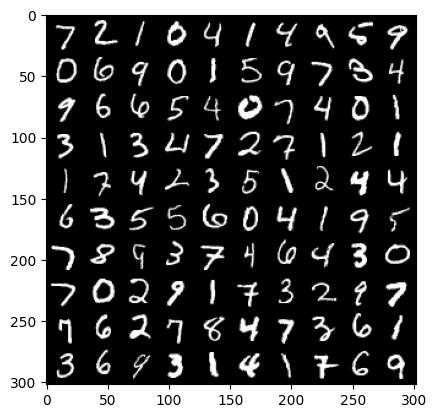

Reconstructed Image:


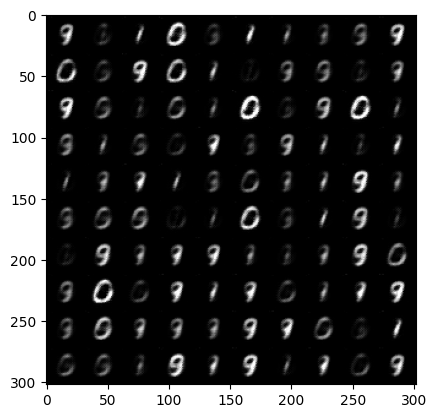

Difference:


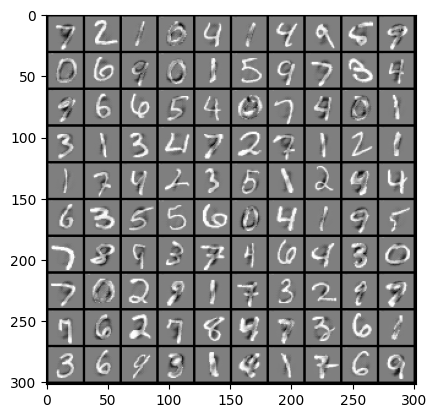



--------------------------------------------------------------------------------


length of losses: 5
Epoch: 2
Training:


  0%|          | 0/468 [00:00<?, ?it/s]

Loss: 0.095 	 L_rec: 0.094 	 L_dist: 0.000 	 L_spar: 0.001 	 L_disen: 0.000


Compute and record loss on test set:
EVAL
conditonal= False
device= cuda


  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.084 	 L_rec: 0.083 	 L_dist: 0.000 	 L_spar: 0.001 	 L_disen: 0.000
latent image mean: -0.009 	 latent image std: 0.142


--------------------------------------------------------------------------------


length of losses: 5
Epoch: 3
Training:


  0%|          | 0/468 [00:00<?, ?it/s]

Loss: 0.079 	 L_rec: 0.079 	 L_dist: 0.000 	 L_spar: 0.001 	 L_disen: 0.000


Compute and record loss on test set:
EVAL
conditonal= False
device= cuda


  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.076 	 L_rec: 0.075 	 L_dist: 0.000 	 L_spar: 0.001 	 L_disen: 0.000
latent image mean: -0.007 	 latent image std: 0.159


--------------------------------------------------------------------------------


length of losses: 5
Epoch: 4
Training:


  0%|          | 0/468 [00:00<?, ?it/s]

Loss: 0.073 	 L_rec: 0.072 	 L_dist: 0.000 	 L_spar: 0.001 	 L_disen: 0.000


Compute and record loss on test set:
EVAL
conditonal= False
device= cuda


  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.073 	 L_rec: 0.072 	 L_dist: 0.000 	 L_spar: 0.001 	 L_disen: 0.000
latent image mean: -0.006 	 latent image std: 0.149


--------------------------------------------------------------------------------


length of losses: 5
Epoch: 5
Training:


  0%|          | 0/468 [00:00<?, ?it/s]

Loss: 0.072 	 L_rec: 0.071 	 L_dist: 0.000 	 L_spar: 0.001 	 L_disen: 0.000


Compute and record loss on test set:
EVAL
conditonal= False
device= cuda


  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.071 	 L_rec: 0.071 	 L_dist: 0.000 	 L_spar: 0.001 	 L_disen: 0.000
latent image mean: -0.007 	 latent image std: 0.142


--------------------------------------------------------------------------------


length of losses: 5
Epoch: 6
Training:


  0%|          | 0/468 [00:00<?, ?it/s]

Loss: 0.071 	 L_rec: 0.071 	 L_dist: 0.000 	 L_spar: 0.001 	 L_disen: 0.000


Compute and record loss on test set:
EVAL
conditonal= False
device= cuda


  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.071 	 L_rec: 0.070 	 L_dist: 0.000 	 L_spar: 0.001 	 L_disen: 0.000
latent image mean: -0.006 	 latent image std: 0.142


--------------------------------------------------------------------------------


length of losses: 5
Epoch: 7
Training:


  0%|          | 0/468 [00:00<?, ?it/s]

Loss: 0.071 	 L_rec: 0.070 	 L_dist: 0.000 	 L_spar: 0.001 	 L_disen: 0.000


Compute and record loss on test set:
EVAL
conditonal= False
device= cuda


  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.070 	 L_rec: 0.070 	 L_dist: 0.000 	 L_spar: 0.001 	 L_disen: 0.000
latent image mean: -0.007 	 latent image std: 0.140


--------------------------------------------------------------------------------


length of losses: 5
Epoch: 8
Training:


  0%|          | 0/468 [00:00<?, ?it/s]

Loss: 0.070 	 L_rec: 0.069 	 L_dist: 0.000 	 L_spar: 0.001 	 L_disen: 0.000


Compute and record loss on test set:
EVAL
conditonal= False
device= cuda


  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.070 	 L_rec: 0.069 	 L_dist: 0.000 	 L_spar: 0.000 	 L_disen: 0.000
latent image mean: -0.006 	 latent image std: 0.137


--------------------------------------------------------------------------------


length of losses: 5
Epoch: 9
Training:


  0%|          | 0/468 [00:00<?, ?it/s]

Loss: 0.069 	 L_rec: 0.069 	 L_dist: 0.000 	 L_spar: 0.001 	 L_disen: 0.000


Compute and record loss on test set:
EVAL
conditonal= False
device= cuda


  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.069 	 L_rec: 0.069 	 L_dist: 0.000 	 L_spar: 0.000 	 L_disen: 0.000
latent image mean: -0.008 	 latent image std: 0.136


--------------------------------------------------------------------------------


length of losses: 5
Epoch: 10
Training:


  0%|          | 0/468 [00:00<?, ?it/s]

Loss: 0.069 	 L_rec: 0.068 	 L_dist: 0.000 	 L_spar: 0.000 	 L_disen: 0.000


Compute and record loss on test set:
EVAL
conditonal= False
device= cuda


  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.069 	 L_rec: 0.068 	 L_dist: 0.000 	 L_spar: 0.000 	 L_disen: 0.000
latent image mean: -0.005 	 latent image std: 0.137
Original Image:


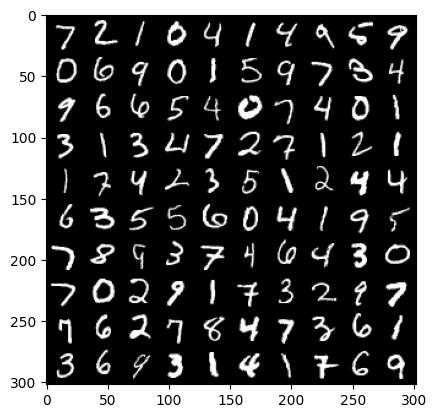

Reconstructed Image:


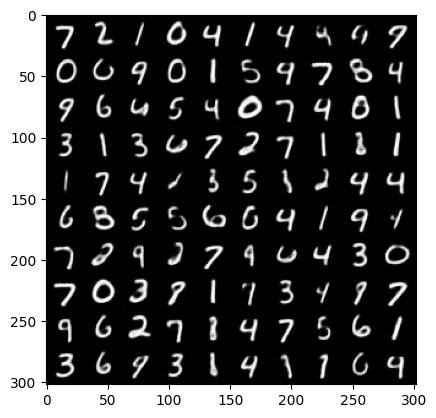

Difference:


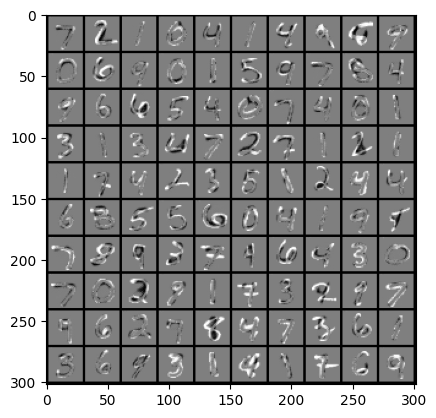



--------------------------------------------------------------------------------


Finished Training
conditonal= False


################################################################################
################################################################################




In [15]:
### Training INN as Autoencoder with MNIST
model = train_bottleneck(num_epoch, get_model, 'l1', modelname, milestones, latent_dim_lst, trainloader,
                            None, testloader, a_distr=0, a_disen=0, lr_init=lr_init, l2_reg=l2_reg, device=device, save_model=True)

In [16]:
model

ReversibleGraphNet(
  (module_list): ModuleList(
    (0): None
    (1): dummy()
    (2-4): 3 x glow_coupling_layer(
      (s1): F_conv(
        (conv1): Conv2d(2, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(100, 4, kernel_size=(1, 1), stride=(1, 1))
      )
      (s2): F_conv(
        (conv1): Conv2d(2, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(100, 4, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (5): haar_multiplex_layer()
    (6-7): 2 x reshape_layer()
    (8): haar_restore_layer()
    (9): rev_multiplicative_layer(
      (s1): F_small_connected(
        (d1): Dropout(p=0.0, inplace=False)
        (fc1): Linear(in_features=392, out_features=180, bias=True)
        (fc3): Linear(in_features=180, out_features=392, bias=True)
        (nl1)

sample:
 [[-0.43731177 -1.00585188 -0.16014145  0.0514296 ]
 [ 0.38909867  0.06818477  0.53759184  0.30993731]
 [ 0.57360007  0.67271763  1.89712039 -0.6657155 ]
 [ 0.94332956 -0.14658561 -0.51232021 -1.12423121]
 [-1.49462633  0.46454136 -0.28285613 -0.02809764]
 [ 0.98572273  0.98922693 -1.20123041 -0.68714313]
 [ 1.11506069  1.02555299  1.44261627 -1.43880793]
 [-1.23779732 -0.18071869  0.9797733   0.85034803]
 [-0.08475707  1.05412449 -1.01782719  1.46441264]
 [-0.6506306   1.44400614 -1.76714941 -0.08456483]
 [-0.87690426  2.92093903  1.29606831 -0.58770106]
 [ 1.44087424 -0.27603803 -0.35563397 -0.37558394]
 [-1.53556598 -0.91740983  0.56420609 -0.01755747]
 [-1.07199596  0.98373183 -2.17025235 -2.07666635]
 [-0.97138298 -0.11280495  1.18806054 -2.37928321]
 [ 1.69192581 -0.84912478  0.31118384  0.5187958 ]
 [ 1.01479823  0.77202969 -0.13146171 -1.22793112]
 [-0.86558745  1.66359163  1.47252424 -0.16013376]
 [-0.18780695 -1.23898777 -0.09933971 -0.74953658]
 [-0.74848896 -1.58387

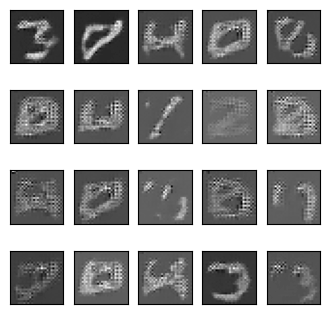

In [17]:
## Replacing latent input with noise
## Artificial bottleneck
batch_size = 128
latent_dim = 4
input_size = 784
x_rnd = torch.rand(batch_size, 1, 28, 28)
#x_rnd = torch.normal(7,2,size=(batch_size, 1, 28, 28))

x_rnd_shape = x_rnd.shape

lat_samples = np.random.normal(loc = 0, scale = 1, size=(batch_size, latent_dim))
zero_samples = np.zeros(shape=(batch_size, input_size - latent_dim))
samples = np.concatenate((lat_samples, zero_samples), axis=1)
print("sample:\n", samples[0:20, 0:4]) # sample:  [-0.56294419 -0.88707191  0.          0.          0.          0.
print("samples shape: ", samples.shape)

# Entire 784 is random
# samples = np.random.normal(size=(batch_size, input_size))

samples_torch = torch.from_numpy(samples)
x_rnd = (samples_torch.view(x_rnd_shape)).float()

## Inference, path forward
#zy_new = model(x_rnd)
#x_gen = model(zy_new, rev=True)

# Generation is in the reverse flow
x_gen = model(x_rnd, rev=True)

# Visualize
x_img = x_rnd.detach().numpy()
#zy_img = zy_new.detach().numpy()
x_gen_img = x_gen.detach().numpy()

fig = plt.figure(figsize=(4, 4))

for idx in np.arange(20):
    #ax=fig.add_subplot(20, 2, 2 * idx + 1, xticks=[], yticks=[])
    #ax.imshow(x_img[idx].reshape(28,28), cmap='gray')

    #ax=fig.add_subplot(20, 3, 3 * idx + 2, xticks=[], yticks=[])
    #ax.imshow(zy_img[idx].reshape(28,28), cmap='gray')

    #ax=fig.add_subplot(20, 1, 1 * idx + 1, xticks=[], yticks=[])
    ax=fig.add_subplot(4, 5, idx + 1, fc = (0,0,0,idx/(20+2)), xticks=[], yticks=[])
    ax.imshow(x_gen_img[idx].reshape(28,28), cmap='gray')